In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from utils import *
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Helvetica'

description =(
'''Take a model with very small size (4,8,8,2). It will function as the *base model*. Only considering weights for pruning, this model has 112 p-params.
With a fixed p-rate of 0.32, a larger model architecture can be calculated, which would have the same number of p-parameters after pruning with (roughly) the p-rate once.
This process is termed "model extension". A model is extended by n, where n is the number of p-levels needed to get it to the size of the base model. n is termed the "extension-level".
The model architectures are restricted to having the same number of hidden layers, and the same number of hidden neurons in each hidden layer.
Therefore, the exact p-rate differs slightly, depending on the extension level.
'''
)

In [4]:
sweep_ids=['wpcowdl5', 'j9lvvxjg', 'a5kr3muw']

try: print('Histories already loaded.') if hc else None
except: hc = load_histories_and_configs(sweep_ids)

# define dataframes to concat
_split = make_split_df(hc)
_levels = make_df(hc, 'extension_levels')
_shape = make_df(hc, 'model_shape').map(lambda shape: shape[1])
_p_params_begin = make_df(hc, 'param_trajectory').map(lambda x: x[0])
#_shape['hidden_dim'] = _shape.map(lambda shape: shape[1])
_splitrange = make_splitrange_df(hc)
_first, _last = make_dfs_at_splitrange(hc, _splitrange)

In [5]:
_active_w = make_df_from_history(hc, 'active-weights-rel', invert=True, drop_first=True)
_loss = make_df_from_history(hc, 'val-loss', invert=True, drop_first=True)

df_loss = pd.concat([_levels, _loss], axis=1).groupby('extension_levels').mean()
df_active_weights = pd.concat([_levels, _active_w], axis=1).groupby('extension_levels').mean()

_active_w_abs = make_df_from_history(hc, 'active-weights-abs', invert=True, drop_first=True)
df_active_weights_abs = pd.concat([_levels, _active_w_abs], axis=1).groupby('extension_levels').mean()

# Hypothesis 
## 'Collateral Damage':
for each p-level, there is 'collateral damage'. Some p-parameters are made inactive or zombious. -> the relative amount of active p-parameters decreases, the more p-levels there are.
### How to test
plot the relative amount of at each level, from each run. If it is true, each run with more levels should have less active p-parameters at the corresponding extension level. Because the networks have the same number of p-parameters at the corresponding levels the comparisson should be fair.

Indeed, the more pruning iterations, generally decrease the percentage of active-weights in the network.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


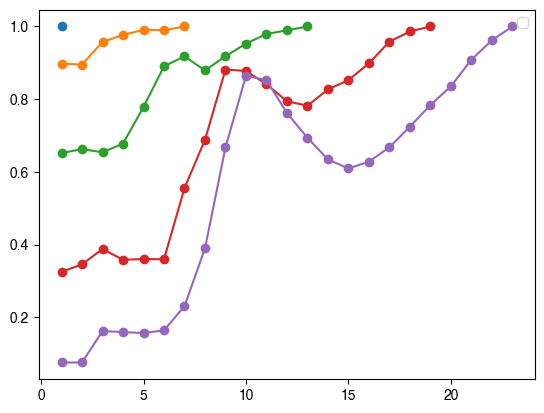

In [6]:
indices = [0, 6, 12, 18, 24]
plt.plot(df_active_weights.iloc[indices].T, marker='o')
plt.legend()
plt.show()

### Peak Performance
The networks seem to reach peak performance around the same number of p-parameters

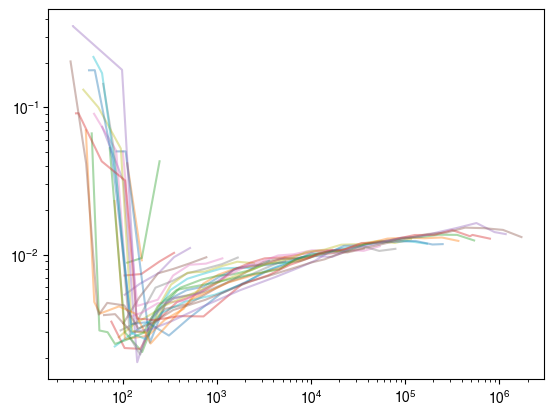

In [7]:
indices = df_active_weights_abs.index

for i in indices:
    x = df_active_weights_abs.loc[i]
    y = df_loss.loc[i]
    plt.plot(x,y, marker='', label=f'e={i}', alpha=0.4)
    
plt.xscale('log'), plt.yscale('log')
# plt.legend()
plt.show()

### When do networks split
and when do they degrade?
Why do networks only start to degrade after 12 extension levels, and continue to do so when extending further?
Lets look at the number of active parameters at the time they split and at the time they degrade.

Do they split earlier, in terms of iteration and in terms of active weights?

Results show some signs that tey split in earlier iterations, but not clearly. Could be noise as well.
However, the more e-levels they have, the less active parameters the have when they split.

/Users/max/Documents/Studium/_Master_Thesis/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


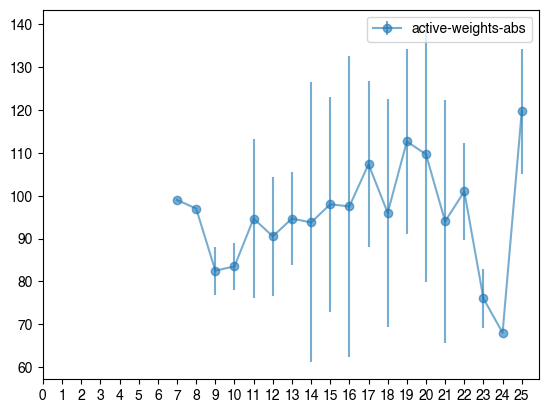

/Users/max/Documents/Studium/_Master_Thesis/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


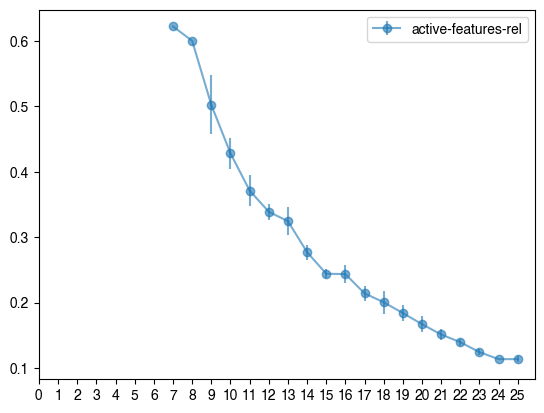

/Users/max/Documents/Studium/_Master_Thesis/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


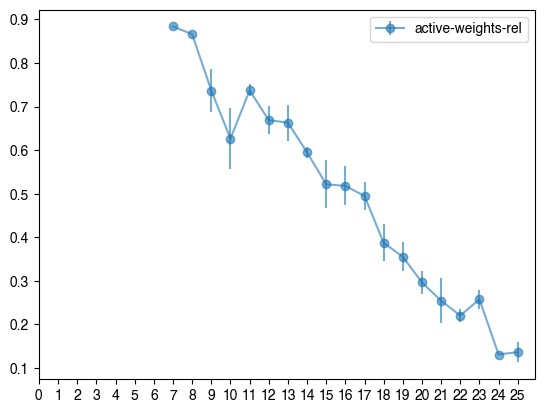

/Users/max/Documents/Studium/_Master_Thesis/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


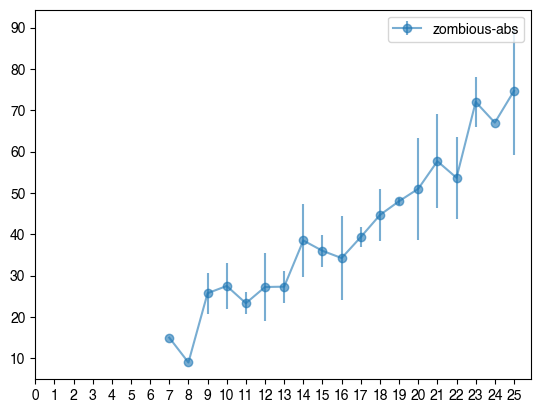

In [43]:
group_df = _levels
source_df = _first
source_keys = [
    'active-weights-abs', 
    'active-features-rel',  
    'active-weights-rel',
    'zombious-abs',
    
    ]

group = make_group(group_df, source_df, source_keys)

for key in source_keys:
    df = mean_std_from_group(group, key)
    errorbar_from_df(df, label=key, marker='o', alpha=0.6)

Do they degrade earlier?
They clearly degrade with more p-parameters available, meaning they degrade in earlier iterations. However, the number of active parameters stays about the same, independent of the number of e-levels.

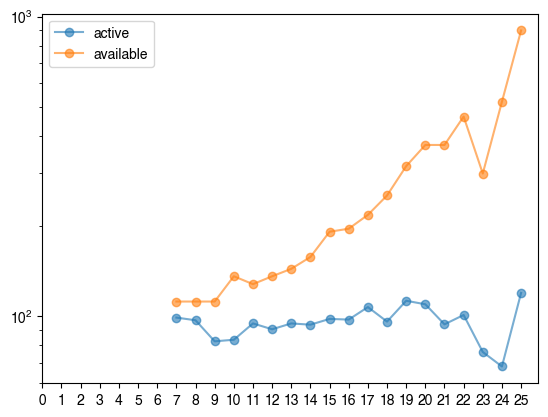

In [44]:
active = pd.concat([_levels, _first['active-weights-abs']],axis=1).groupby('extension_levels').mean()
plt.plot(active, label='active', marker='o', alpha=0.6)

#active_features = pd.concat([_levels, _first['active-features-abs']],axis=1).groupby('extension_levels').mean()
#plt.plot(active_features, label='features', marker='o', alpha=0.6)

pparams = pd.concat([_levels, _first['pparams']],axis=1).groupby('extension_levels').mean()
plt.plot(pparams, label='available', marker='o', alpha=0.6)

plt.xticks(active.index)
plt.legend()
plt.yscale('log')
plt.show()

when Looking at weights and biases together, the Split networks actually are larger when increasing the e-level. this is mainly due to more biases in the network.

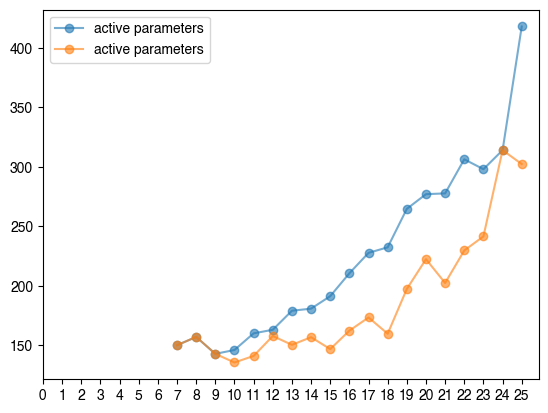

In [45]:
fz = pd.concat([_levels, _first['active-abs']],axis=1).groupby('extension_levels').mean()
plt.plot(fz, label='active parameters', marker='o', alpha=0.6)

lz = pd.concat([_levels, _last['active-abs']],axis=1).groupby('extension_levels').mean()
plt.plot(lz, label='active parameters', marker='o', alpha=0.6)

plt.xticks(active.index)
plt.legend()
plt.show()

# Can this be true?
That there are 7 times the number of biases than weights ACTIVE in the network?

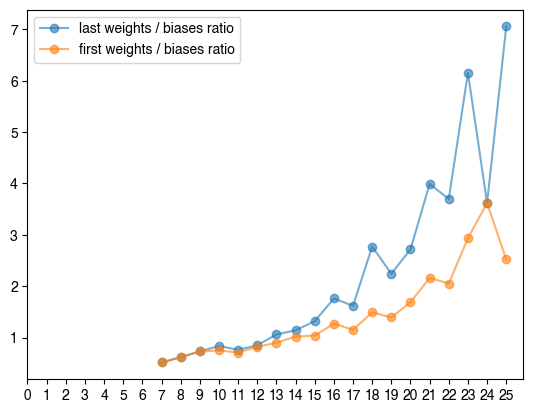

In [46]:
_first['active-features-abs'] / _first['active-weights-abs']
fz = pd.concat([_levels, _first['active-features-abs'] / _first['active-weights-abs']],axis=1).groupby('extension_levels').mean()
lz = pd.concat([_levels, _last['active-features-abs'] / _last['active-weights-abs']],axis=1).groupby('extension_levels').mean()
plt.plot(lz, label='last weights / biases ratio', marker='o', alpha=0.6)
plt.plot(fz, label='first weights / biases ratio', marker='o', alpha=0.6)

plt.xticks(active.index)
plt.legend()
plt.show()

In [ ]:
yfirst = pd.concat([_levels, _last['active-weights-rel']],axis=1).groupby('extension_levels').mean()
ylast = pd.concat([_levels, _first['active-weights-rel']],axis=1).groupby('extension_levels').mean()

plt.plot(yfirst, label='first', marker='o', alpha=0.6)
plt.plot(ylast, label='last', marker='o', alpha=0.6)
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# Plotting a heatmap with a logarithmic colorbar using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='tab20', aspect='auto', norm=LogNorm())
plt.colorbar(label='Logarithmic Value')
plt.xticks(ticks=range(data.shape[1]), labels=data.columns)
plt.yticks(ticks=range(data.shape[0]), labels=data.index)
plt.title("Heatmap of DataFrame (Logarithmic Scale)")
plt.show()

In [ ]:
title='Collateral Damage'

w_active = pd.DataFrame([h['active-weights-abs'] for h,_ in hc]).reset_index().drop(0, axis=1)
df = pd.concat([_levels,w_active], axis=1).sort_values('extension_levels')

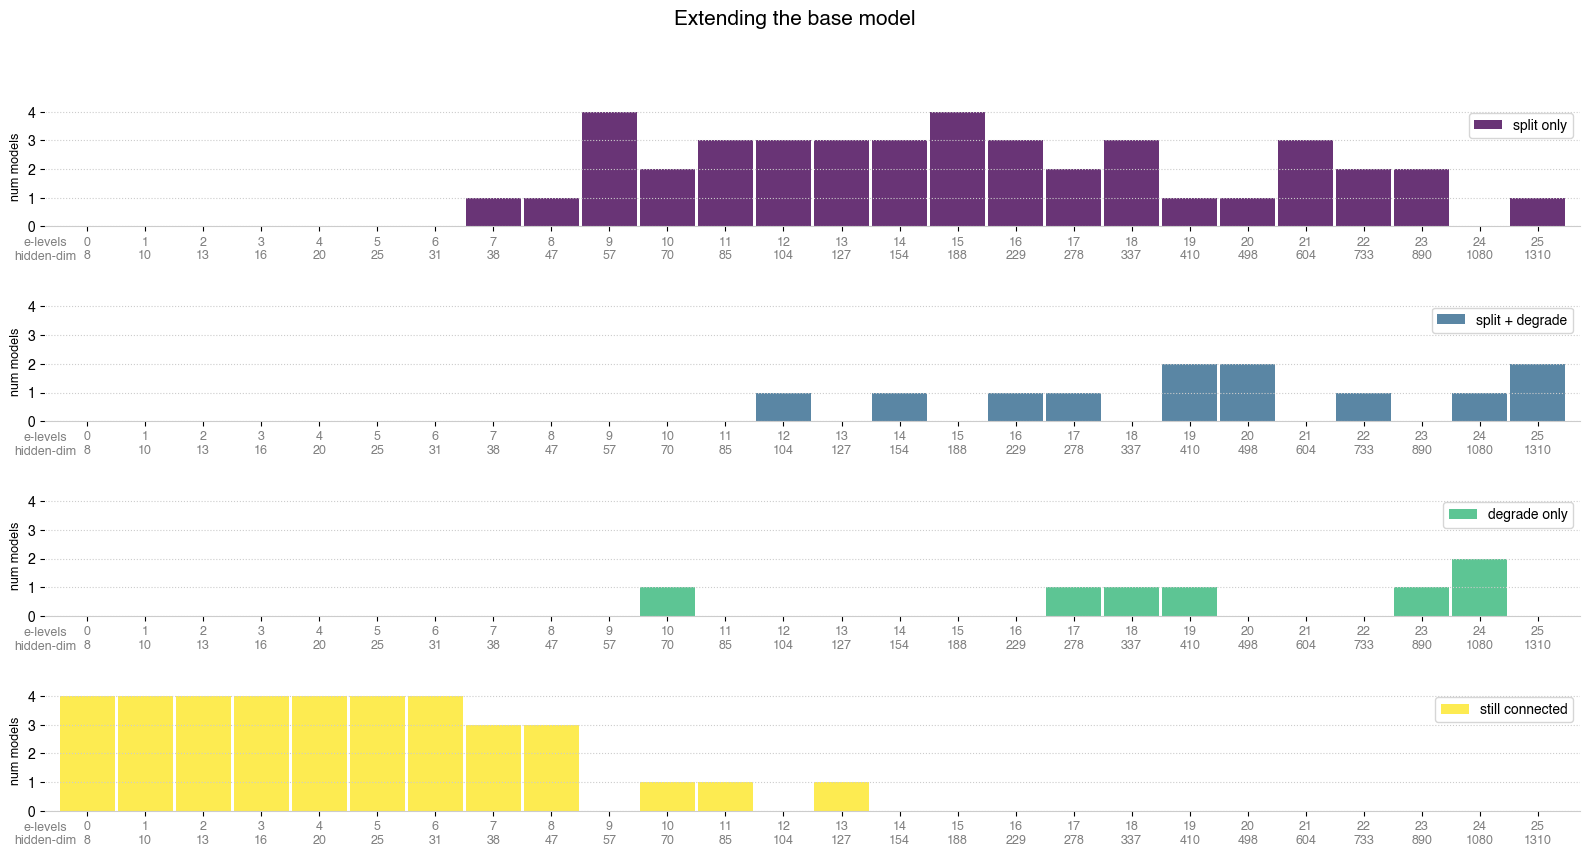

In [47]:
title='Extending the base model'

ydf = pd.concat([_split, _levels], axis=1).groupby('extension_levels').sum()
xdf = pd.concat([_shape, _levels], axis=1).drop_duplicates()
xdf['xticklabels'] = xdf.apply(lambda df: f"{df['extension_levels']}\n{df['model_shape']}", axis=1)
xdf = xdf.sort_values('extension_levels').reset_index(drop=True)
xdf['xticks'] = xdf.index


xlabel='e-levels\nhidden-dim'
description=(
'''
'''
)
fig, axes = plt.subplots(nrows=len(ydf.columns), figsize=(16,9), sharey=True, sharex=False)
fig.suptitle(title, fontweight='regular', fontsize=15, fontname='Helvetica')
fig.text(0.5, 0.95, description, ha='center', va='top', fontsize=9, color=(0.1,0.1,0.1))

# plot the data
ydf.plot.bar(
    ax=axes,
    subplots=True,
    width=0.95,  
    alpha=0.8,
    colormap='viridis',
    rot=0,
)

for ax in axes:
    ax.set_yticks(np.arange(np.max(ydf)+1))
    ax.set_xticks(xdf['xticks'])
    ax.set_xticklabels(xdf['xticklabels'], fontsize=9, color='gray')
    ax.set_ylabel('num models', fontsize=9)
    ax.set_xlabel(xlabel, fontsize=9, color='gray')
    ax.xaxis.set_label_coords(0.0, -0.087)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
set_style(axes)